# Attention: Attention! 
*сказ про котов и карты активации, by [Data author](https://t.me/jdata_blog)*

Этот ноутбук сопровождает пост [Attention: Attention!](https://teletype.in/@jdata_blog/B0T5Mn4DjF9). Присоединяйтесь к чтению и запускайте код =)

In [1]:
from __future__ import unicode_literals, print_function, division
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import re
import random
from matplotlib import ticker

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

## **Набор данных**

Работа проведена с открытыми данными с ресурса [tatoeba.org](https://tatoeba.org/). 

Набор данных содержит два столбца:
- `rus` — предложение на русском
- `eng` — предложение на английском

In [2]:
# Загрузим набор данных
total_df = pd.read_csv('data/rus_eng.csv')
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730519 entries, 0 to 730518
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   rus     730519 non-null  object
 1   eng     730519 non-null  object
dtypes: object(2)
memory usage: 11.1+ MB


Предобработаем датасет, уберем дубликаты и для ускорения обучения моделей возьмём только 100000 наблюдений. 

In [3]:
# Функция для предобработки строк датасета

def normalizeString(s):
    s = s.lower().strip() #приводим к нижнему регистру и обрезаем пробелы с краёв
    s = re.sub(r"[^\w\s?]", "", s) # удаляем знаки препинания, кроме вопросительного
    s = re.sub(r"([?])", r" \1", s) # добавляем пробел перед вопросительным знаком
    return s.strip() # снова обрезаем строку с краёв

In [4]:
# Предобработка строк
total_df['rus'] = total_df['rus'].apply(lambda x: normalizeString(x))
total_df['eng'] = total_df['eng'].apply(lambda x: normalizeString(x))

In [5]:
# Удаляем дубликаты
total_df.drop_duplicates(inplace=True)

Смотрим, что вышло. 

In [6]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 724991 entries, 0 to 730518
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   rus     724991 non-null  object
 1   eng     724991 non-null  object
dtypes: object(2)
memory usage: 16.6+ MB


In [7]:
# Берем сэмпл данных
df_sample = total_df.sample(100000, random_state=42)

## Текст для модели — преобразование данных в "читаемый" сетью вид

Чтобы использовать слова в качестве input'ов и target'ов,  необходима кодировка. Она релизована в виде словаря, ставящего в соответствие каждому слову число. Для этого написан класс `Lang`. 

`SOS` и `EOS` — токены старта (start) и концы (end) последовательности соответственно. 


In [8]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self):
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Счетчик уникальных слов (начиная с 2, так как есть SOS и EOS)

    def addSentences(self, sentences: pd.Series):
        """Добавляет все предложения из pandas Series."""
        sentences.apply(self.addSentence)

    def addSentence(self, sentence):
        """Добавляет отдельное предложение в словарь."""
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        """Добавляет слово в словарь или обновляет счетчик, если слово уже существует."""
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [9]:
# Извлечение релевантных столбцов

firtst_lang = df_sample['rus']
target_lang = df_sample['eng']

# Создание из столбцов пар input-target
pairs = list(zip(firtst_lang, target_lang))

Чтобы ещё чуть-чуть ускорить эксперимент, данные отфильтрованы так, что взяты наблюдения, короче или равные 10 токенам. Это дало  возможность начать получать интересные результаты за 40 минут (Macbook M3 pro, cpu, mps не использовались, я только привыкаю к мабукам =)). 

In [10]:
MAX_LENGTH = 10

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

# Вызовем фильтрацию
pairs = filterPairs(pairs) 

print("Отфильтровано до %s  пар (pairs) последовательностей" % len(pairs))
print(random.choice(pairs))

Отфильтровано до 89851  пар (pairs) последовательностей
('что ты можешь рассказать мне о случившемся ?', 'what can you tell me about what happened ?')


In [11]:
# Инициализируем классы для хранения языков 
input_lang = Lang()
second_lang = Lang()

for pair in pairs:
     input_lang.addSentence(pair[0])
     second_lang.addSentence(pair[1])

print("Посчитанные слова в inputs и outputs:")
print(f'Input sentences содержат {input_lang.n_words} уникальных значений\n Output sentences содержат {second_lang.n_words} уникальных значений')

Посчитанные слова в inputs и outputs:
Input sentences содержат 31868 уникальных значений
 Output sentences содержат 13078 уникальных значений


Ну и ещё немного вспомогательных функций, чтобы получать тензоры из пар. 

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')] # предложение в вектор индексов

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence) 
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(second_lang, pair[1])
    return (input_tensor, target_tensor)

Формирование даталоадера. 

In [13]:
N = len(pairs)
BATCH_SIZE = 200

input_ids = np.zeros((N, MAX_LENGTH), dtype=np.int32) # заготовки для хранения наших входных indexes
target_ids = np.zeros((N, MAX_LENGTH), dtype=np.int32) # заготовки для хранения наших целевых indexes

for idx, (inp, tgt) in enumerate(pairs):
    inp_ids = indexesFromSentence(input_lang, inp)
    inp_ids.append(EOS_token)

    tgt_ids = indexesFromSentence(second_lang, tgt)
    tgt_ids.append(EOS_token)

    input_ids[idx, :len(inp_ids)] = inp_ids 
    target_ids[idx, :len(tgt_ids)] = tgt_ids

train_data = TensorDataset(torch.LongTensor(input_ids), torch.LongTensor(target_ids))

train_sampler = RandomSampler(train_data)

train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

# Загрузка предобученных моделей, для получения различных карт внимания. 
## Attention — Bahdanau & Luong

Подходов к вычислению внимания существует много, например Bahdanau-Attention, Luong-Attention, Self-attention и другие. Также, само внимание можно по разному улучшать и наделять информацией, через:
- Обычное скалярное произведение: $e_i = \{(s_i, h_0), ..., (s_i, h_n)\} = [s_i h_j^T]_{j=0}^n$ — dot attention, aka Luong Attention
- Мультипликативное внимание с матрицей весов $W$: $e_i = [s_iWh_j^T]_{j=0}^n$, где $W$ - обучаемая матрица весов (это получается обобщение скалярного произведения) - general attention, aka Luong Attention
- Bahdanau attention (MLP): $e_{ij} = tanh(h_jW_1 + s_iW_2)v$, где $W_1, W_2$ - обучаемые матрицы весов, а $v$ - обучаемый вектор весов.

Кроме того, во всех примерах выше:
$(h_0, h_1, ..., h_n)$ - векторы скрытого состояния кодировщика
$(s_0 = h_n, s_1, ..., s_m)$ - векторы скрытого состояния декодировщика

Для эксперимента реализованы Bahdanau attention и Luong Attention, Luong Attention обобщаются способы: 

- dot attention: $s_i^Th_j$ — скалярно перемножаем скрытые слои энкодера и декодера
- general attention: $s_i^TW_1h_j$ —  перемножаем скрытые слои энкодера и декодера с промежуточной матрицей весов между ними
- concat attention: $v^Ttanh(W_1[s_i;h_j])$ — умножаем обучаемый вектор весов на тангенс от взвешенного векторного произведения скрытых слоёв энкодера и декодера (почти Bahdanau)

Реализованные подходы к вниманию вы можете найти в файле `attentions.py`, а сами модели в файле `models.py`.

In [14]:
from models import EncoderRNN, AttnDecoderRNN

hidden_size = 128
device = 'cpu'

# LUONG DOT
dot_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
dot_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words, method='dot').to(device)

# LUONG GENERAL
general_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
general_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words, method='general').to(device)

# LUONG CONCAT
concat_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
concat_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words, method='concat').to(device)

# BAHDANAU
bahdanau_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
bahdanau_decoder = AttnDecoderRNN(hidden_size, second_lang.n_words).to(device)

Luong Attention with dot is used
Luong Attention with general is used
Luong Attention with concat is used
Bahdanau Attention is used


In [15]:
# DOT ATTENTION
dot_encoder.load_state_dict(torch.load('models/dot_encoder', weights_only=True))
dot_encoder.eval()

dot_decoder.load_state_dict(torch.load('models/dot_decoder', weights_only=True))
dot_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(13078, 128)
  (attention): LuongAttention()
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=13078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [16]:
# GENERAL
general_encoder.load_state_dict(torch.load('models/general_encoder', weights_only=True))
general_encoder.eval()

general_decoder.load_state_dict(torch.load('models/general_decoder', weights_only=True))
general_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(13078, 128)
  (attention): LuongAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=13078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [17]:
# CONCAT
concat_encoder.load_state_dict(torch.load('models/concat_encoder', weights_only=True))
concat_encoder.eval()

concat_decoder.load_state_dict(torch.load('models/concat_decoder', weights_only=True))
concat_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(13078, 128)
  (attention): LuongAttention(
    (Wa): Linear(in_features=256, out_features=128, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=13078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [18]:
# BAHDANAU
bahdanau_encoder.load_state_dict(torch.load('models/bahdanau_encoder', weights_only=True))
bahdanau_encoder.eval()

bahdanau_decoder.load_state_dict(torch.load('models/bahdanau_decoder', weights_only=True))
bahdanau_decoder.eval()

AttnDecoderRNN(
  (embedding): Embedding(13078, 128)
  (attention): BahdanauAttention(
    (Wa): Linear(in_features=128, out_features=128, bias=True)
    (Ua): Linear(in_features=128, out_features=128, bias=True)
    (Va): Linear(in_features=128, out_features=1, bias=True)
  )
  (gru): GRU(256, 128, batch_first=True)
  (out): Linear(in_features=128, out_features=13078, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

## Визуализация вниманий. 
Рассмотрим предложение "я люблю кошек", потому что я люблю кошек. И оценим, как с ними справятся модели, обученные в одинаковых условиях, но с разными механизмами внимания. 

In [19]:
encoders_decoders_pairs = [(dot_encoder, dot_decoder), (concat_encoder, concat_decoder), (general_encoder, general_decoder), (bahdanau_encoder, bahdanau_decoder)]
keys = ['DOT', 'CONCAT', 'GENERAL', 'BAHDANAU']

In [20]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('EOS')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

input = я люблю кошек
output = i like cats but cats dont smoke EOS
input = я люблю кошек
output = i love cats insects EOS


/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_63609/3946583591.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_63609/3946583591.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_63609/3946583591.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_63609/3946583591.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

input = я люблю кошек
output = i like cats but i love cats EOS
input = я люблю кошек
output = i love cats cats EOS


/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_63609/3946583591.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_63609/3946583591.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_63609/3946583591.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/var/folders/3j/4bpmrzsj6q3f151lfj_j6fp00000gn/T/ipykernel_63609/3946583591.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

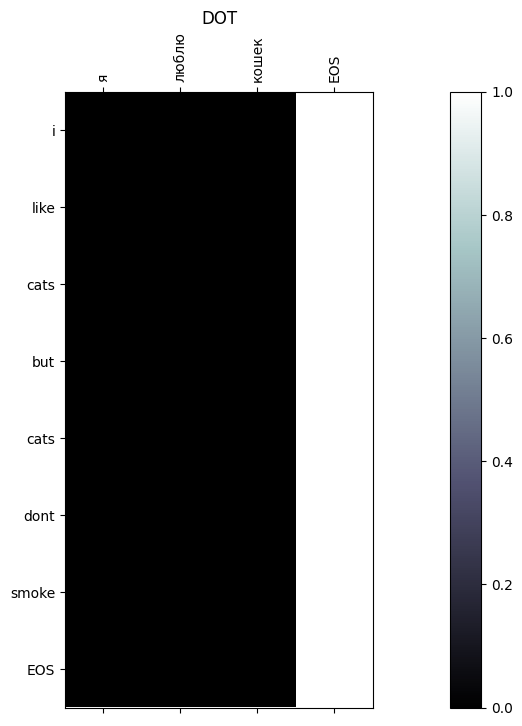

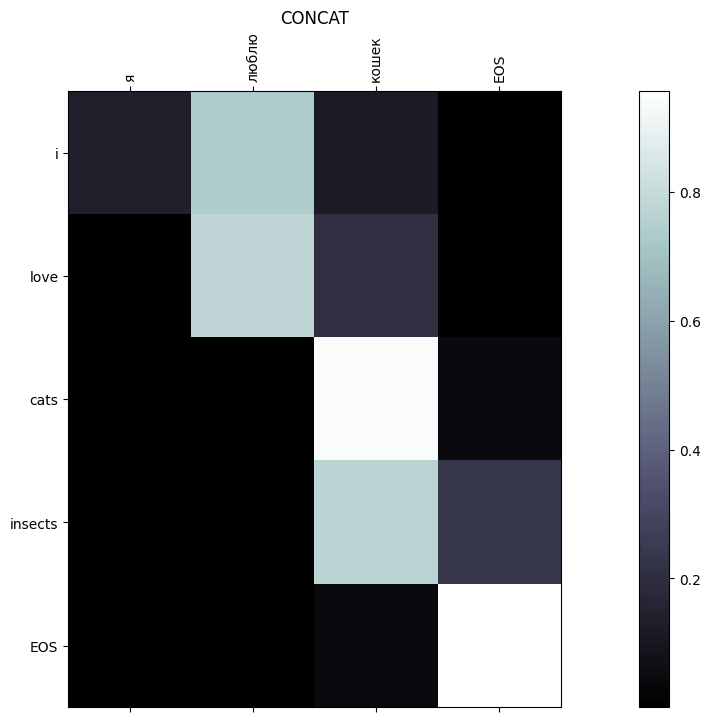

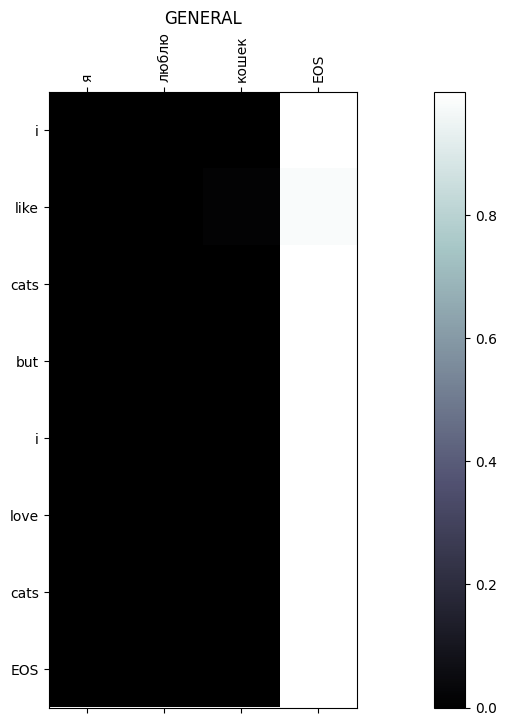

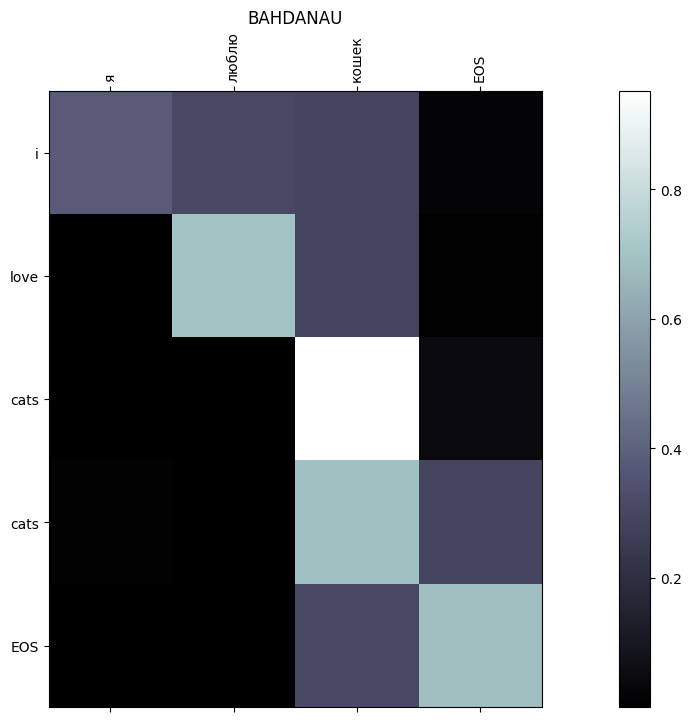

In [21]:
def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['EOS'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))


def evaluateAndShowAttention(input_sentence, title, encoder, decoder):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, second_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])
    plt.title(title)
    plt.savefig(f'{title}.png')



for enc_dec, key in zip(encoders_decoders_pairs, keys):
    enc, dec = enc_dec
    evaluateAndShowAttention('я люблю кошек', key, enc, dec)


Загрузим численные результаты. 

In [22]:
train_results_data = pd.read_csv('results_data.csv', 
                                 index_col=0)

train_results_data


,mean loss,median loss,training time minutes
without,1.056864,0.827356,32.760236
dot,1.061731,0.835960,36.256661
general,1.032140,0.806987,37.387139
concat,0.856844,0.599806,40.020917
bahdanau,0.374914,0.339739,39.651543


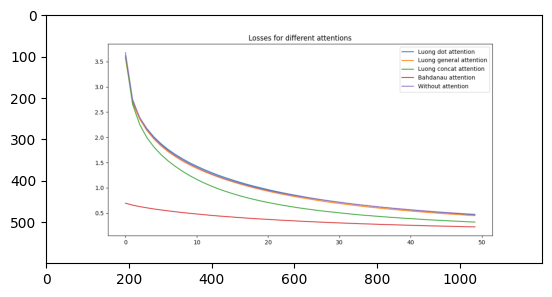

In [23]:
img = Image.open('results/Losses.png')
plt.imshow(img)

Лучшим подходом к вниманию действительно оказался Bahdanau attention. Время обучения увеличилось примерно на 20% и функция потерь оказалась ниже более чем в два раза. 

## Внимание в explainable AI.
С момента популяризации, механизм attention также стал распространяться в области XAI. Действительно, ведь согласно интуитивному определению — веса внимания — прямое отражение того, на что "смотрит" модель. И в эксперименте это абсолютно видно. 

Но внимание **не позволяет*** сделать "прозрачную" модель. 
 В настоящее время показано, что:


- возможно полностью изменить веса внимания и добиться того же прогноза (также веса внимания допускают и другие состязательные вмешательства);

- веса внимания не обязательно коррелируют (часто — вообще не коррелируют) с другими методами объяснения;

Кроме того, опровергая attention в качестве объяснения, исследователи отмечают, что внимание строится не на основе самих слов, а на основе их эмбеддингов, что тоже умаляет точность построенных карт. Данный факт можно оспорить, сформулировав гипотезу о том, что модель имитирует пространство слов корпуса в векторном пространстве. Но насколько эта гипотеза является правдой, в силу больших размерностей, открытый вопрос. 


## Общий вывод о внимании
Attention — сильный инструмент, улучшающий качество модели. На свойство объяснимости attention также влияет, однако является не более и не менее чем ещё одной попыткой глубже понять скрытые зависимости, изучаемые моделью.


Спасибо за ваше внимание, друзья!
Всегда рада видеть вашу обратную связь в [Data Blog'е](https://t.me/jdata_blog), где я пишу про объяснимость моделей и свой опыт в области Data Science. 

*До новых встреч и доброго вам времени,*

*Ваш Дата-автор!*

Материалы:
- https://github.com/wenhaofang/Seq2SeqAtn/blob/main/modules/module1.py 
- https://wikidocs.net/166653 
- [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/pdf/1508.04025)